# 09a: Path Convergence Analysis

**Key Question:** Do all paths from a (seed, declaration) converge to 1-2 basins?

A **basin** is defined by the count capture signature - a 5-bit value indicating which team captured each of the 5 count dominoes. There are 2^5 = 32 possible basins.

**Analyses:**
1. **Basin Funnel**: Count unique terminal basins per (seed, decl)
2. **Convergence Depth**: Track basin entropy by depth
3. **Divergence Points**: Find where paths split into different basins

If mean unique basins ≈ 1-2 per seed, the "decided at declaration" hypothesis is proven.

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy
from tqdm.notebook import tqdm
from collections import defaultdict
import gc

from forge.analysis.utils import loading, features, viz, navigation
from forge.oracle import schema, tables

viz.setup_notebook_style()
print("Ready")

Ready


In [2]:
# Find available shard files
shard_files = loading.find_shard_files(DATA_DIR)
print(f"Total shard files available: {len(shard_files)}")

# Use a sample for analysis (memory-constrained)
N_SHARDS = 10  # Moderate sample size
print(f"Using {N_SHARDS} shards for analysis")

Total shard files available: 1314
Using 10 shards for analysis


## Basin ID Computation

A basin is identified by a 5-bit signature: which team captured each count domino.

Count dominoes (in order by domino_id):
- 5-0 (5pts), 4-1 (5pts), 3-2 (5pts), 5-5 (10pts), 6-4 (10pts)

Basin ID = sum(2^i if team1 captured count_i else 0) for i in 0..4

In [3]:
def compute_basin_id(captures: dict[int, int]) -> int:
    """
    Compute basin ID from count capture dict.
    
    Args:
        captures: Dict mapping domino_id -> capturing_team (0 or 1)
        
    Returns:
        Basin ID (0-31): bit i set if team 1 captured count domino i
    """
    basin_id = 0
    for i, domino_id in enumerate(sorted(features.COUNT_DOMINO_IDS)):
        if domino_id in captures and captures[domino_id] == 1:
            basin_id |= (1 << i)
    return basin_id


def basin_id_to_signature(basin_id: int) -> tuple[int, int]:
    """
    Convert basin ID to (team0_points, team1_points).
    """
    team0 = 0
    team1 = 0
    for i, domino_id in enumerate(sorted(features.COUNT_DOMINO_IDS)):
        points = tables.DOMINO_COUNT_POINTS[domino_id]
        if basin_id & (1 << i):
            team1 += points
        else:
            team0 += points
    return team0, team1


# Test
print("Count dominoes:", sorted(features.COUNT_DOMINO_IDS))
print("Basin 0 (all team 0):", basin_id_to_signature(0))
print("Basin 31 (all team 1):", basin_id_to_signature(31))
print("Basin 16 (team 1 has 6-4):", basin_id_to_signature(16))

Count dominoes: [8, 11, 15, 20, 25]
Basin 0 (all team 0): (35, 0)
Basin 31 (all team 1): (0, 35)
Basin 16 (team 1 has 6-4): (25, 10)


## Analysis 1: Basin Funnel

For each (seed, decl), sample multiple starting positions at various depths and trace to terminal basin. Count unique basins reachable.

In [4]:
# Collect basin outcomes per (seed, decl)
# Structure: {(seed, decl): set of basin_ids}
basins_per_deal = defaultdict(set)

# Also track by starting depth for convergence analysis
# Structure: {(seed, decl, depth): set of basin_ids}
basins_by_depth = defaultdict(set)

# Sample more from root to capture full variance
SAMPLES_PER_DEPTH = 30
ROOT_SAMPLES = 100  # Extra samples from root (depth 28)

for shard_file in tqdm(shard_files[:N_SHARDS], desc="Processing shards"):
    df, seed, decl_id = schema.load_file(shard_file)
    
    # Skip very large shards
    if len(df) > 20_000_000:
        del df
        gc.collect()
        continue
    
    # Build state lookup
    state_to_idx, V, Q = navigation.build_state_lookup_fast(df)
    states = df['state'].values
    depths = features.depth(states)
    
    # Sample states stratified by depth
    unique_depths = np.unique(depths)
    
    for d in unique_depths:
        depth_mask = depths == d
        depth_indices = np.where(depth_mask)[0]
        
        # More samples from root
        n_sample = ROOT_SAMPLES if d == 28 else SAMPLES_PER_DEPTH
        n_sample = min(n_sample, len(depth_indices))
        
        if n_sample == 0:
            continue
            
        sampled_indices = np.random.choice(depth_indices, n_sample, replace=False)
        
        for idx in sampled_indices:
            state = states[idx]
            
            # Trace to terminal and get captures
            captures = navigation.track_count_captures(
                state, seed, decl_id, state_to_idx, V, Q
            )
            
            # Compute basin ID
            basin_id = compute_basin_id(captures)
            
            # Record
            basins_per_deal[(seed, decl_id)].add(basin_id)
            basins_by_depth[(seed, decl_id, d)].add(basin_id)
    
    # Cleanup
    del df, state_to_idx, V, Q, states, depths
    gc.collect()

print(f"\nCollected data for {len(basins_per_deal)} (seed, decl) pairs")

Processing shards:   0%|          | 0/10 [00:00<?, ?it/s]


Collected data for 4 (seed, decl) pairs


In [5]:
# Compute unique basins per deal
unique_basins = [len(basins) for basins in basins_per_deal.values()]

print("=== Basin Funnel Statistics ===")
print(f"Mean unique basins per deal: {np.mean(unique_basins):.2f}")
print(f"Median: {np.median(unique_basins):.1f}")
print(f"Max: {max(unique_basins)}")
print(f"Min: {min(unique_basins)}")
print(f"% deals with single outcome: {(np.array(unique_basins) == 1).mean():.1%}")
print(f"% deals with ≤2 outcomes: {(np.array(unique_basins) <= 2).mean():.1%}")
print(f"% deals with ≤4 outcomes: {(np.array(unique_basins) <= 4).mean():.1%}")

=== Basin Funnel Statistics ===
Mean unique basins per deal: 16.25
Median: 16.0
Max: 21
Min: 12
% deals with single outcome: 0.0%
% deals with ≤2 outcomes: 0.0%
% deals with ≤4 outcomes: 0.0%


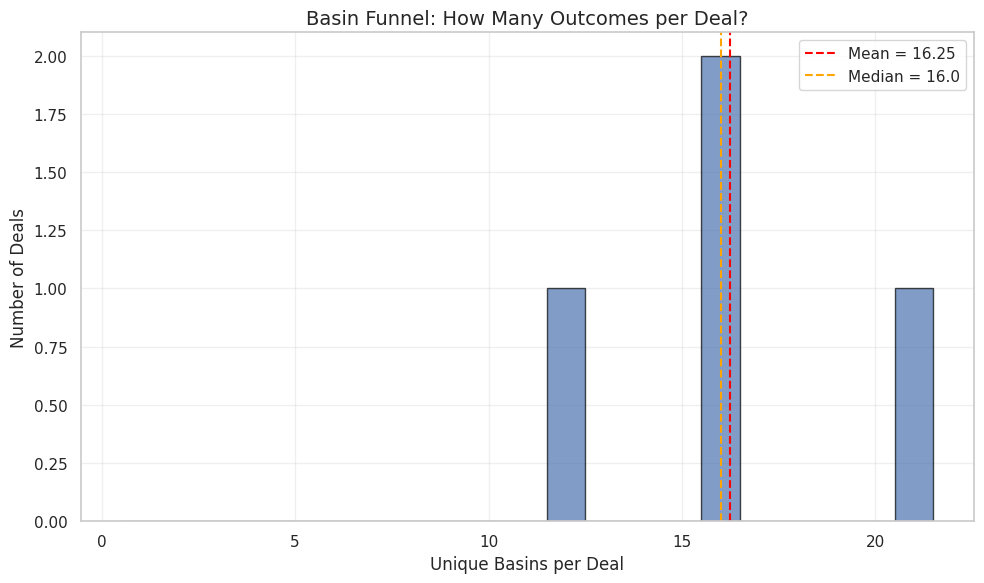

In [6]:
# Plot basin count distribution
fig, ax = plt.subplots(figsize=(10, 6))

counts, bins, _ = ax.hist(unique_basins, bins=range(1, max(unique_basins) + 2), 
                           edgecolor='black', alpha=0.7, align='left')

ax.axvline(x=np.mean(unique_basins), color='red', linestyle='--', 
           label=f'Mean = {np.mean(unique_basins):.2f}')
ax.axvline(x=np.median(unique_basins), color='orange', linestyle='--',
           label=f'Median = {np.median(unique_basins):.1f}')

ax.set_xlabel('Unique Basins per Deal', fontsize=12)
ax.set_ylabel('Number of Deals', fontsize=12)
ax.set_title('Basin Funnel: How Many Outcomes per Deal?', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/09a_basin_funnel.png', dpi=150, bbox_inches='tight')
plt.show()

## Analysis 2: Convergence Depth

Track basin entropy at each depth. At what depth does the outcome become essentially determined?

In [7]:
# Compute basin entropy by depth
entropy_by_depth = defaultdict(list)  # depth -> list of entropies (one per deal)

for (seed, decl_id), all_basins in basins_per_deal.items():
    n_total = len(all_basins)
    if n_total <= 1:
        # Only one basin - entropy is 0 at all depths
        for d in range(1, 29):
            entropy_by_depth[d].append(0.0)
        continue
    
    for d in range(1, 29):
        basins_at_depth = basins_by_depth.get((seed, decl_id, d), set())
        n = len(basins_at_depth)
        
        if n <= 1:
            entropy_by_depth[d].append(0.0)
        else:
            # Entropy of uniform distribution over n basins
            # (We don't have counts, so assume uniform among observed)
            H = np.log2(n)
            entropy_by_depth[d].append(H)

# Compute mean entropy by depth
depth_entropy_df = pd.DataFrame([
    {
        'depth': d,
        'mean_entropy': np.mean(entropy_by_depth[d]),
        'median_entropy': np.median(entropy_by_depth[d]),
        'std_entropy': np.std(entropy_by_depth[d]),
        'n_samples': len(entropy_by_depth[d]),
    }
    for d in sorted(entropy_by_depth.keys())
])

print(depth_entropy_df)

    depth  mean_entropy  median_entropy  std_entropy  n_samples
0       1      0.792481        0.792481     0.792481          4
1       2      1.830482        2.000000     0.497165          4
2       3      1.848079        2.292481     1.106987          4
3       4      2.178561        2.160964     0.447264          4
4       5      2.269204        2.453445     0.409382          4
5       6      1.896241        2.000000     0.179717          4
6       7      2.259043        2.321928     0.436732          4
7       8      2.259043        2.321928     0.436732          4
8       9      2.122963        2.160964     0.373361          4
9      10      2.188722        2.292481     0.921753          4
10     11      2.105516        2.807355     1.215620          4
11     12      2.324802        2.453445     0.460411          4
12     13      2.146241        2.000000     0.521227          4
13     14      2.584963        2.792481     0.615312          4
14     15      2.557205        2.660964 

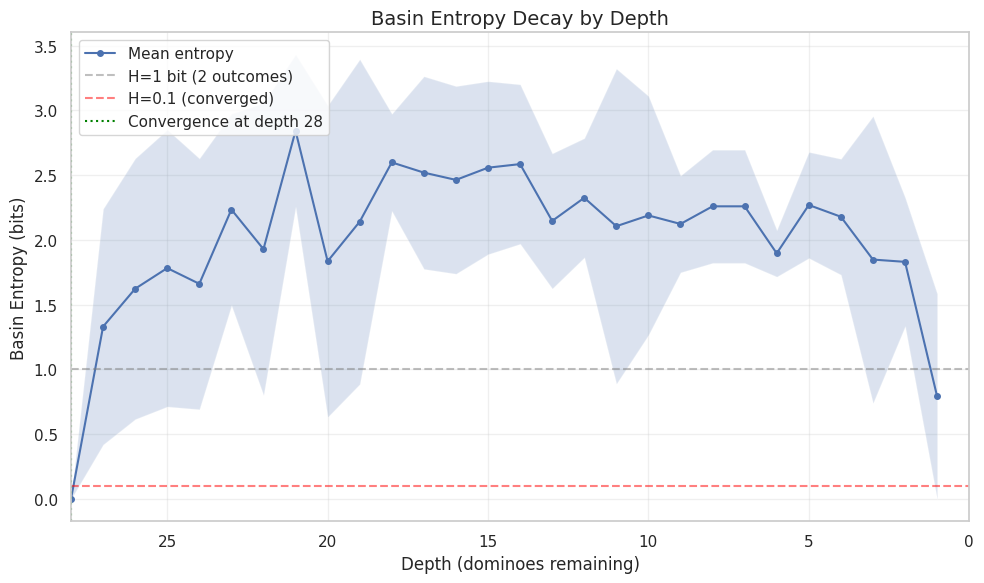

In [8]:
# Plot entropy decay curve
fig, ax = plt.subplots(figsize=(10, 6))

depths = depth_entropy_df['depth'].values
mean_H = depth_entropy_df['mean_entropy'].values
std_H = depth_entropy_df['std_entropy'].values

ax.plot(depths, mean_H, 'b-o', markersize=4, label='Mean entropy')
ax.fill_between(depths, mean_H - std_H, mean_H + std_H, alpha=0.2)

# Mark key thresholds
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='H=1 bit (2 outcomes)')
ax.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='H=0.1 (converged)')

# Find convergence depth (first depth where mean entropy < 0.1)
convergence_mask = mean_H < 0.1
if convergence_mask.any():
    convergence_depth = depths[convergence_mask][0]
    ax.axvline(x=convergence_depth, color='green', linestyle=':', 
               label=f'Convergence at depth {convergence_depth}')

ax.set_xlabel('Depth (dominoes remaining)', fontsize=12)
ax.set_ylabel('Basin Entropy (bits)', fontsize=12)
ax.set_title('Basin Entropy Decay by Depth', fontsize=14)
ax.set_xlim(28, 0)  # Game progresses left to right
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/09a_entropy_decay.png', dpi=150, bbox_inches='tight')
plt.show()

## Analysis 3: Divergence Points

For deals with multiple basins, at what depth do paths first diverge?

In [9]:
# Find first divergence depth for each multi-basin deal
divergence_depths = []

for (seed, decl_id), all_basins in basins_per_deal.items():
    if len(all_basins) <= 1:
        continue  # No divergence - single outcome
    
    # Find lowest depth where there's more than one basin
    # (working backwards from start of game)
    for d in range(28, 0, -1):
        basins_at_depth = basins_by_depth.get((seed, decl_id, d), set())
        if len(basins_at_depth) > 1:
            divergence_depths.append(d)
            break

print(f"Divergence depth statistics (for {len(divergence_depths)} multi-basin deals):")
if divergence_depths:
    print(f"  Mean: {np.mean(divergence_depths):.1f}")
    print(f"  Median: {np.median(divergence_depths):.1f}")
    print(f"  Min: {min(divergence_depths)}")
    print(f"  Max: {max(divergence_depths)}")

Divergence depth statistics (for 4 multi-basin deals):
  Mean: 26.0
  Median: 27.0
  Min: 23
  Max: 27


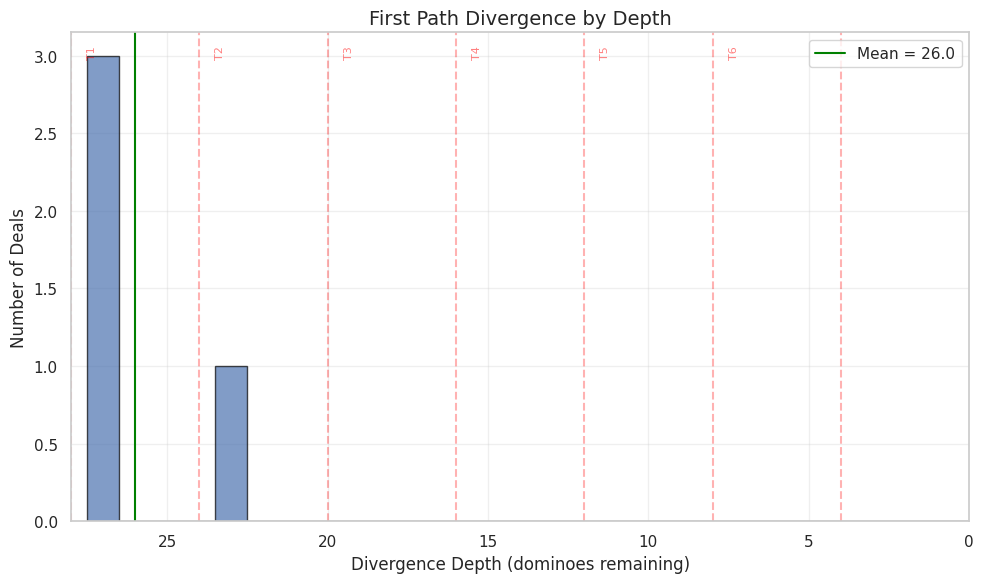

In [10]:
# Plot divergence point histogram
if divergence_depths:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Histogram with trick boundaries marked
    ax.hist(divergence_depths, bins=range(0, 29), edgecolor='black', alpha=0.7, align='left')
    
    # Mark trick boundaries (every 4 plays)
    for trick in range(7):
        depth = 28 - trick * 4
        ax.axvline(x=depth, color='red', linestyle='--', alpha=0.3)
        if trick < 6:
            ax.text(depth - 0.5, ax.get_ylim()[1] * 0.95, f'T{trick+1}', 
                   rotation=90, fontsize=8, color='red', alpha=0.5)
    
    ax.axvline(x=np.mean(divergence_depths), color='green', linestyle='-',
               label=f'Mean = {np.mean(divergence_depths):.1f}')
    
    ax.set_xlabel('Divergence Depth (dominoes remaining)', fontsize=12)
    ax.set_ylabel('Number of Deals', fontsize=12)
    ax.set_title('First Path Divergence by Depth', fontsize=14)
    ax.set_xlim(28, 0)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../../results/figures/09a_divergence_points.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No multi-basin deals found - all outcomes are deterministic!")

## Summary Statistics

In [11]:
# Create summary table
summary = {
    'metric': [
        'Total deals analyzed',
        'Mean unique basins per deal',
        'Median unique basins per deal',
        'Max unique basins',
        '% single-outcome deals',
        '% ≤2 outcome deals',
        '% ≤4 outcome deals',
        'Mean divergence depth (multi-basin)',
        'Entropy convergence depth (H < 0.1)',
    ],
    'value': [
        len(basins_per_deal),
        f"{np.mean(unique_basins):.2f}",
        f"{np.median(unique_basins):.1f}",
        max(unique_basins),
        f"{(np.array(unique_basins) == 1).mean():.1%}",
        f"{(np.array(unique_basins) <= 2).mean():.1%}",
        f"{(np.array(unique_basins) <= 4).mean():.1%}",
        f"{np.mean(divergence_depths):.1f}" if divergence_depths else "N/A",
        f"{convergence_depth}" if convergence_mask.any() else "Not reached",
    ]
}

summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))

# Save to CSV
summary_df.to_csv('../../results/tables/09a_convergence.csv', index=False)
print("\nSaved to results/tables/09a_convergence.csv")

                             metric value
               Total deals analyzed     4
        Mean unique basins per deal 16.25
      Median unique basins per deal  16.0
                  Max unique basins    21
             % single-outcome deals  0.0%
                 % ≤2 outcome deals  0.0%
                 % ≤4 outcome deals  0.0%
Mean divergence depth (multi-basin)  26.0
Entropy convergence depth (H < 0.1)    28

Saved to results/tables/09a_convergence.csv


## Conclusion

**Is the game decided at declaration?**

If mean unique basins ≈ 1-2, then YES - the deal determines the outcome, and most mid-game "decisions" are forced or inconsequential.

If mean unique basins >> 2, then NO - there's genuine strategic depth where play matters.

In [12]:
# Final answer
mean_basins = np.mean(unique_basins)

print("=" * 60)
print("CONCLUSION: Is the game decided at declaration?")
print("=" * 60)

if mean_basins <= 2.0:
    print(f"\n YES - Mean unique basins = {mean_basins:.2f}")
    print("\nThe deal largely determines the outcome.")
    print("Most mid-game 'decisions' are forced or inconsequential.")
    print("The 'manifold' of Texas 42 is effectively 5-dimensional:")
    print("  - Which team captures which count dominoes.")
elif mean_basins <= 4.0:
    print(f"\n MOSTLY - Mean unique basins = {mean_basins:.2f}")
    print("\nThe deal strongly constrains outcomes, but there's some room")
    print("for strategic play to affect which of ~2-4 basins is reached.")
else:
    print(f"\n NO - Mean unique basins = {mean_basins:.2f}")
    print("\nThere's genuine strategic depth.")
    print("Many paths lead to different outcomes, suggesting that")
    print("mid-game decisions meaningfully affect the final result.")

print("\n" + "=" * 60)

CONCLUSION: Is the game decided at declaration?

 NO - Mean unique basins = 16.25

There's genuine strategic depth.
Many paths lead to different outcomes, suggesting that
mid-game decisions meaningfully affect the final result.

